# PROG8245 – Embedding, Clustering, and Vectorization Workshop

## Team Members

| Name            | Student ID |
|-----------------|------------|
| Krishna Reddy   | 905861     |
| Mandeep Singh   | 8989361    |
| Kumari Nikitha  | 9053016    |

---

## Dataset

- **Name**: Simple English Wikipedia Corpus  
- **Source**: HuggingFace (`wikipedia`, version `20220301.simple`)  
- **License**: CC BY-SA 3.0  
- **Link**: [https://huggingface.co/datasets/wikipedia](https://huggingface.co/datasets/wikipedia)

---

## GitHub Repository

- **Project Repository**: [https://github.com/nikitha2002-bot/EmbeddingClusteringVectorizationWorkshop.git](https://github.com/nikitha2002-bot/EmbeddingClusteringVectorizationWorkshop.git)

> **Talking Point**: The repository contains the complete Jupyter Notebook, supporting scripts, and documentation necessary to reproduce all experiments conducted during the workshop.


### 📌 Workshop Summary

This notebook implements:

- An NLP preprocessing pipeline
- 4 probabilistic language models (Unigram, Bigram, Trigram, N-gram)
- Word2Vec (predictive) embeddings
- GloVe (count-based) embeddings
- Brown Clustering and LSA (as bonus enhancements)

Each major step includes clear documentation and "talking points" for review and reflection.


## 1. Document Collection and Normalization

We use the **Wikitext-2** dataset from HuggingFace—a compact and clean English corpus based on Wikipedia articles—ideal for NLP experimentation.

### Steps Followed:

- **Load Dataset**: Retrieved using the HuggingFace `datasets` library.
- **Filter Lines**: Removed empty lines and formatting markers (e.g., headings).
- **Normalize Text**:
  - Converted text to lowercase
  - Removed punctuation and numbers
  - Stripped extra whitespace

### Interpretation:

Text normalization ensures consistency across the corpus by reducing variability in tokens. This step is essential before vectorization, as it improves the quality of word embeddings and clustering outcomes by focusing the model on core linguistic patterns instead of noise.


In [1]:
# 📥 Load and normalize corpus
from datasets import load_dataset
import re, string

# Load Wikitext-2 dataset
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")

# Filter lines: remove headers/empty lines
raw_texts = [line for line in dataset['text'] if line.strip() and not line.startswith('=')]

# Normalize: lowercase, remove punctuation, numbers, whitespace
def normalize_text(texts, remove_numbers=True):
    normalized = []
    for line in texts:
        line = line.lower()
        line = re.sub(f"[{re.escape(string.punctuation)}]", "", line)
        if remove_numbers:
            line = re.sub(r"\d+", "", line)
        line = re.sub(r"\s+", " ", line).strip()
        if line:
            normalized.append(line)
    return normalized

# Normalize first 100 lines for speed
normalized_corpus = normalize_text(raw_texts[:100])

# Preview
for i in range(5):
    print(f"Normalized {i+1}: {normalized_corpus[i]}")


Normalized 1: valkyria chronicles iii
Normalized 2: senjō no valkyria unrecorded chronicles japanese 戦場のヴァルキュリア lit valkyria of the battlefield commonly referred to as valkyria chronicles iii outside japan is a tactical role playing video game developed by sega and mediavision for the playstation portable released in january in japan it is the third game in the valkyria series employing the same fusion of tactical and real time gameplay as its predecessors the story runs parallel to the first game and follows the nameless a penal military unit serving the nation of gallia during the second europan war who perform secret black operations and are pitted against the imperial unit calamaty raven
Normalized 3: the game began development in carrying over a large portion of the work done on valkyria chronicles ii while it retained the standard features of the series it also underwent multiple adjustments such as making the game more forgiving for series newcomers character designer raita honj

## 2. Tokenization

Tokenization is the process of breaking down text into individual units called tokens—typically words or meaningful subwords.

We use the `TreebankWordTokenizer` from NLTK, known for its effective handling of punctuation and contractions, making it suitable for general-purpose English text.

### Purpose:

This step transforms each normalized sentence into a list of tokens, setting the stage for subsequent preprocessing steps such as stopword removal and lemmatization.

### Interpretation:

Accurate tokenization is critical in NLP pipelines. A well-tokenized corpus ensures that downstream models learn patterns from meaningful linguistic units rather than noisy or fragmented text.


In [2]:
from nltk.tokenize import TreebankWordTokenizer

def tokenize_text(text_list):
    tokenizer = TreebankWordTokenizer()
    tokenized = []
    for sentence in text_list:
        tokens = tokenizer.tokenize(sentence)
        tokenized.append(tokens)
    return tokenized

# Apply tokenizer
tokenized_corpus = tokenize_text(normalized_corpus)

# Preview results
for i in range(3):
    print(f"Sentence {i+1}: {tokenized_corpus[i]}")


Sentence 1: ['valkyria', 'chronicles', 'iii']
Sentence 2: ['senjō', 'no', 'valkyria', 'unrecorded', 'chronicles', 'japanese', '戦場のヴァルキュリア', 'lit', 'valkyria', 'of', 'the', 'battlefield', 'commonly', 'referred', 'to', 'as', 'valkyria', 'chronicles', 'iii', 'outside', 'japan', 'is', 'a', 'tactical', 'role', 'playing', 'video', 'game', 'developed', 'by', 'sega', 'and', 'mediavision', 'for', 'the', 'playstation', 'portable', 'released', 'in', 'january', 'in', 'japan', 'it', 'is', 'the', 'third', 'game', 'in', 'the', 'valkyria', 'series', 'employing', 'the', 'same', 'fusion', 'of', 'tactical', 'and', 'real', 'time', 'gameplay', 'as', 'its', 'predecessors', 'the', 'story', 'runs', 'parallel', 'to', 'the', 'first', 'game', 'and', 'follows', 'the', 'nameless', 'a', 'penal', 'military', 'unit', 'serving', 'the', 'nation', 'of', 'gallia', 'during', 'the', 'second', 'europan', 'war', 'who', 'perform', 'secret', 'black', 'operations', 'and', 'are', 'pitted', 'against', 'the', 'imperial', 'unit', '

## 3. Stopword Removal

Stopwords are frequently occurring words—such as "the", "is", "in"—that often carry little semantic weight in natural language processing tasks. Their removal helps reduce noise and improves the focus on more meaningful terms.

We use NLTK’s standard English stopword list to filter out these words from our tokenized corpus.

### Purpose:

By eliminating stopwords, we enhance the quality of feature representations used in embedding and clustering. This step is especially valuable when building frequency-based models like TF-IDF or Word2Vec.

### Interpretation:

Stopword removal ensures that the model learns from content-bearing words rather than filler terms, resulting in more discriminative and efficient text representations.


In [3]:
from nltk.corpus import stopwords
import nltk

# Download stopwords if not already present
nltk.download('stopwords')

# Initialize stopword set
stop_words = set(stopwords.words('english'))

def remove_stopwords(tokenized_corpus):
    filtered = []
    for tokens in tokenized_corpus:
        filtered_tokens = [word for word in tokens if word not in stop_words]
        filtered.append(filtered_tokens)
    return filtered

# Apply stopword removal
filtered_corpus = remove_stopwords(tokenized_corpus)

# Preview filtered output
for i in range(3):
    print(f"Filtered Sentence {i+1}: {filtered_corpus[i]}")


Filtered Sentence 1: ['valkyria', 'chronicles', 'iii']
Filtered Sentence 2: ['senjō', 'valkyria', 'unrecorded', 'chronicles', 'japanese', '戦場のヴァルキュリア', 'lit', 'valkyria', 'battlefield', 'commonly', 'referred', 'valkyria', 'chronicles', 'iii', 'outside', 'japan', 'tactical', 'role', 'playing', 'video', 'game', 'developed', 'sega', 'mediavision', 'playstation', 'portable', 'released', 'january', 'japan', 'third', 'game', 'valkyria', 'series', 'employing', 'fusion', 'tactical', 'real', 'time', 'gameplay', 'predecessors', 'story', 'runs', 'parallel', 'first', 'game', 'follows', 'nameless', 'penal', 'military', 'unit', 'serving', 'nation', 'gallia', 'second', 'europan', 'war', 'perform', 'secret', 'black', 'operations', 'pitted', 'imperial', 'unit', 'calamaty', 'raven']
Filtered Sentence 3: ['game', 'began', 'development', 'carrying', 'large', 'portion', 'work', 'done', 'valkyria', 'chronicles', 'ii', 'retained', 'standard', 'features', 'series', 'also', 'underwent', 'multiple', 'adjustment

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kittu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 4. Lemmatization

Lemmatization is the process of reducing words to their root or dictionary form (lemma). This step improves consistency in token representation across the corpus.

For example:  
- "running", "runs", and "ran" are all reduced to → "run"

We use NLTK’s `WordNetLemmatizer` to perform lemmatization, which considers the morphological analysis of words to produce accurate lemmas.

### Purpose:

Lemmatization helps unify variations of a word under a single form, which improves the quality of word embeddings and reduces feature sparsity.

### Interpretation:

By mapping inflected words to a common base, we ensure that models treat semantically identical terms as a single unit, enhancing generalization and improving clustering or classification outcomes.


In [4]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')  # Required for WordNet mappings

lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokenized_corpus):
    lemmatized = []
    for tokens in tokenized_corpus:
        lemmas = [lemmatizer.lemmatize(token) for token in tokens]
        lemmatized.append(lemmas)
    return lemmatized

lemmatized_corpus = lemmatize_tokens(filtered_corpus)

# Preview result
for i in range(3):
    print(f"Lemmatized Sentence {i+1}: {lemmatized_corpus[i]}")

# This is the final preprocessed corpus to be used in all downstream models
final_corpus = lemmatized_corpus

# Display 5 processed sentences
for i, sent in enumerate(final_corpus[:5]):
    print(f"Processed Sentence {i+1}: {sent}")


[nltk_data] Downloading package wordnet to C:\Users\kittu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\kittu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Lemmatized Sentence 1: ['valkyria', 'chronicle', 'iii']
Lemmatized Sentence 2: ['senjō', 'valkyria', 'unrecorded', 'chronicle', 'japanese', '戦場のヴァルキュリア', 'lit', 'valkyria', 'battlefield', 'commonly', 'referred', 'valkyria', 'chronicle', 'iii', 'outside', 'japan', 'tactical', 'role', 'playing', 'video', 'game', 'developed', 'sega', 'mediavision', 'playstation', 'portable', 'released', 'january', 'japan', 'third', 'game', 'valkyria', 'series', 'employing', 'fusion', 'tactical', 'real', 'time', 'gameplay', 'predecessor', 'story', 'run', 'parallel', 'first', 'game', 'follows', 'nameless', 'penal', 'military', 'unit', 'serving', 'nation', 'gallia', 'second', 'europan', 'war', 'perform', 'secret', 'black', 'operation', 'pitted', 'imperial', 'unit', 'calamaty', 'raven']
Lemmatized Sentence 3: ['game', 'began', 'development', 'carrying', 'large', 'portion', 'work', 'done', 'valkyria', 'chronicle', 'ii', 'retained', 'standard', 'feature', 'series', 'also', 'underwent', 'multiple', 'adjustment',

## 5. Unigram Language Model

The **Unigram language model** assumes that each word in a sentence is generated independently of others. Though simplistic, it forms the foundation for more complex probabilistic models and is useful for estimating sentence likelihoods.

### Steps Performed:

- **Corpus Flattening**: The entire tokenized corpus is flattened into a single list of words.
- **Word Frequency Count**: Each word's frequency is tallied.
- **Probability Calculation**: The probability of each word is computed as:

  \[
  P(w) = \frac{\text{count}(w)}{\text{total number of tokens}}
  \]

- **Sentence Probability**: Determined by multiplying the probabilities of all words in a sentence.
- **Log Probability**: Also computed for better numerical stability and interpretability:

  \[
  \log P(\text{sentence}) = \sum_{i=1}^{n} \log P(w_i)
  \]

### Interpretation:

Although the unigram model oversimplifies language by ignoring context and word order, it serves as a baseline for comparing more advanced models like bigrams or neural language models. It is especially useful for understanding frequency-driven probability estimation.


In [5]:
from collections import Counter

# Flatten the corpus to get a list of all tokens
flat_tokens = [word for sentence in final_corpus for word in sentence]

# Count word frequencies (unigrams)
unigram_counts = Counter(flat_tokens)

# Total number of tokens
total_unigram_tokens = sum(unigram_counts.values())

# Compute unigram probabilities: P(w) = count(w) / total
unigram_probs = {word: count / total_unigram_tokens for word, count in unigram_counts.items()}


In [6]:
import math

def unigram_sentence_probability(sentence_tokens, prob_dict):
    probability = 1.0
    log_prob = 0.0
    
    for word in sentence_tokens:
        prob = prob_dict.get(word, 1e-6)  # Use small fallback prob for unseen words
        probability *= prob
        log_prob += math.log(prob)
    
    return probability, log_prob

# Sample sentence
sample_sentence = "king i"
sample_tokens = [lemmatizer.lemmatize(w.lower()) for w in sample_sentence.split() if w.isalpha()]

# Estimate probability
prob, log_prob = unigram_sentence_probability(sample_tokens, unigram_probs)

print(f"Unigram Probability: {prob:.6e}")
print(f"Log Probability: {log_prob:.4f}")
print("Tokens:", sample_tokens)


Unigram Probability: 1.000000e-12
Log Probability: -27.6310
Tokens: ['king', 'i']


## 6. Bigram Language Model

The **Bigram model** estimates the probability of a word based on its immediate predecessor, introducing context into the language modeling process. It follows the conditional probability formula:

\[
P(w_2 \mid w_1) = \frac{\text{Count}(w_1, w_2)}{\text{Count}(w_1)}
\]

### Steps Performed:

- **Unigram and Bigram Counting**: Computed from the lemmatized corpus.
- **Conditional Probability Estimation**: Applied minimal smoothing to handle unseen word pairs.
- **Sentence Probability Function**: Implemented a reusable function that:
  - Multiplies conditional probabilities for a given sentence
  - Returns both the raw and log-probabilities

### Interpretation:

The Bigram model significantly improves contextual understanding over the Unigram model by incorporating word-to-word transitions. However, it is still limited by data sparsity—especially for rare or unseen bigram combinations—making it less robust for long or diverse text sequences.


In [7]:
from collections import defaultdict, Counter

# Count unigrams again (for denominator)
unigram_counts = Counter([word for sentence in final_corpus for word in sentence])

# Count bigrams
bigram_counts = Counter()
for sentence in final_corpus:
    for i in range(len(sentence) - 1):
        bigram = (sentence[i], sentence[i+1])
        bigram_counts[bigram] += 1

# Compute bigram probabilities: P(w2 | w1)
bigram_probs = defaultdict(lambda: 1e-6)  # Smoothing for unseen bigrams
for (w1, w2), count in bigram_counts.items():
    bigram_probs[(w1, w2)] = count / unigram_counts[w1]


In [8]:
def bigram_sentence_probability(tokens, prob_dict, unigram_counts):
    probability = 1.0
    log_prob = 0.0

    for i in range(1, len(tokens)):
        w1, w2 = tokens[i-1], tokens[i]
        prob = prob_dict.get((w1, w2), 1e-6)  # fallback for unseen
        probability *= prob
        log_prob += math.log(prob)

    return probability, log_prob

# Try this sentence again
sample_sentence = "king i"
sample_tokens = [lemmatizer.lemmatize(w.lower()) for w in sample_sentence.split() if w.isalpha()]

# Compute
prob_bigram, log_prob_bigram = bigram_sentence_probability(sample_tokens, bigram_probs, unigram_counts)

# Output
print(f"Bigram Probability: {prob_bigram:.6e}")
print(f"Log Probability: {log_prob_bigram:.4f}")
print("Tokens:", sample_tokens)


Bigram Probability: 1.000000e-06
Log Probability: -13.8155
Tokens: ['king', 'i']


## 6. Bigram Language Model

The **Bigram language model** estimates the probability of a word based on the word that precedes it, introducing basic context into sentence modeling.

\[
P(w_2 \mid w_1) = \frac{\text{Count}(w_1, w_2)}{\text{Count}(w_1)}
\]

### Key Steps:

- **Count Frequencies**: Extract unigram and bigram frequencies from the lemmatized corpus.
- **Compute Conditional Probabilities**: Estimate bigram probabilities with light smoothing to handle unseen word pairs.
- **Reusable Probability Function**:
  - Calculates the sentence probability based on chained bigram probabilities.
  - Returns both standard and log-scaled probabilities for numerical stability.

### Interpretation:

The bigram model improves over unigrams by capturing short-term word dependencies. However, it still faces **data sparsity** issues, especially with rare or unseen word pairs, limiting its scalability to longer or more diverse texts.


In [9]:
from collections import Counter, defaultdict
import math

# Step 1: Count bigrams (context) and trigrams
bigram_context_counts = Counter()
trigram_counts = Counter()

for sentence in final_corpus:
    for i in range(len(sentence) - 2):
        w1, w2, w3 = sentence[i], sentence[i+1], sentence[i+2]
        bigram = (w1, w2)
        trigram = (w1, w2, w3)

        bigram_context_counts[bigram] += 1
        trigram_counts[trigram] += 1

# Step 2: Compute trigram probabilities with smoothing
trigram_probs = defaultdict(lambda: 1e-6)
for trigram in trigram_counts:
    context = trigram[:2]
    trigram_probs[trigram] = trigram_counts[trigram] / bigram_context_counts[context]

# Step 3: Probability function
def trigram_sentence_probability(tokens, prob_dict):
    probability = 1.0
    log_prob = 0.0
    for i in range(2, len(tokens)):
        w1, w2, w3 = tokens[i-2], tokens[i-1], tokens[i]
        prob = prob_dict.get((w1, w2, w3), 1e-6)
        probability *= prob
        log_prob += math.log(prob)
    return probability, log_prob

# Step 4: Evaluate on a sample sentence
sample_sentence = "king is powerful"
sample_tokens = [lemmatizer.lemmatize(w.lower()) for w in sample_sentence.split() if w.isalpha()]

prob_trigram, log_prob_trigram = trigram_sentence_probability(sample_tokens, trigram_probs)

print(f"Trigram Probability: {prob_trigram:.6e}")
print(f"Log Probability: {log_prob_trigram:.4f}")
print("Tokens:", sample_tokens)


Trigram Probability: 1.000000e-06
Log Probability: -13.8155
Tokens: ['king', 'is', 'powerful']


## 7. N-Gram Language Model (Generalized)

To extend beyond unigrams and bigrams, we implement a **generalized N-gram language model** capable of handling any value of N (e.g., trigram, 4-gram, etc.).

### Purpose:

This approach enables richer contextual modeling by considering longer sequences of words. Higher-order N-grams improve prediction accuracy by incorporating deeper linguistic context.

### Highlights:

- **Flexible Design**: A generalized function allows computation of N-gram frequencies and conditional probabilities for any N.
- **Sentence Probability**: The model calculates sentence probability by chaining conditional probabilities of N-gram segments.
- **Log Probability**: Used for stability and interpretability, especially with longer sequences.

### Interpretation:

While higher-order N-gram models capture broader context, they also demand more data to avoid sparsity. This generalization balances flexibility with complexity, allowing experimentation across different sequence lengths.


In [10]:
from collections import Counter, defaultdict
import math

# Step 1: Build generalized N-gram model
def build_ngram_model(corpus, n):
    context_counts = Counter()
    ngram_counts = Counter()

    for sentence in corpus:
        if len(sentence) < n:
            continue
        for i in range(len(sentence) - n + 1):
            ngram = tuple(sentence[i:i+n])
            context = ngram[:-1]

            ngram_counts[ngram] += 1
            context_counts[context] += 1

    # Compute probabilities with fallback
    ngram_probs = defaultdict(lambda: 1e-6)
    for ngram in ngram_counts:
        context = ngram[:-1]
        ngram_probs[ngram] = ngram_counts[ngram] / context_counts[context]
    
    return ngram_probs

# Step 2: Scoring function
def ngram_sentence_probability(tokens, ngram_probs, n):
    prob = 1.0
    log_prob = 0.0

    if len(tokens) < n:
        return 0.0, -9999  # Too short

    for i in range(n - 1, len(tokens)):
        ngram = tuple(tokens[i - n + 1 : i + 1])
        p = ngram_probs.get(ngram, 1e-6)
        prob *= p
        log_prob += math.log(p)

    return prob, log_prob

# Step 3: Run for 4-gram as example
n = 4
ngram_probs = build_ngram_model(final_corpus, n)

sample_sentence = "deep learning improves translation accuracy"
sample_tokens = [lemmatizer.lemmatize(w.lower()) for w in sample_sentence.split() if w.isalpha()]

prob_4gram, log_prob_4gram = ngram_sentence_probability(sample_tokens, ngram_probs, n)

print(f"{n}-gram Probability: {prob_4gram:.6e}")
print(f"Log Probability: {log_prob_4gram:.4f}")
print("Tokens:", sample_tokens)


4-gram Probability: 1.000000e-12
Log Probability: -27.6310
Tokens: ['deep', 'learning', 'improves', 'translation', 'accuracy']


## 8. Bigram Model with Laplace Smoothing

To address the issue of **zero probabilities** caused by unseen bigrams, we implement **Laplace (add-one) smoothing**. This technique adjusts bigram counts and ensures every possible bigram has a non-zero probability.

### Method:

- **Count Adjustment**: Add 1 to each bigram count.
- **Denominator Update**: Add the vocabulary size to the denominator to maintain proper normalization.
- **Formula**:

  \[
  P(w_2 \mid w_1) = \frac{\text{Count}(w_1, w_2) + 1}{\text{Count}(w_1) + V}
  \]

  where \( V \) is the vocabulary size.

### Benefits:

- Prevents zero-probability errors in sentence evaluation.
- Enables more robust performance on rare or unseen bigrams.
- Supports better generalization during testing.

### Interpretation:

Laplace smoothing makes the bigram model more reliable by gracefully handling sparse data. Although it may slightly distort frequent bigram probabilities, it improves overall sentence coverage and avoids critical model failures on new input.


In [11]:
from collections import Counter, defaultdict
import math

# Step 1: Build Laplace-smoothed bigram model
def build_bigram_model_laplace(corpus):
    unigram_counts = Counter([word for sentence in corpus for word in sentence])
    bigram_counts = Counter()
    vocab = set(unigram_counts.keys())
    V = len(vocab)

    for sentence in corpus:
        for i in range(len(sentence) - 1):
            bigram = (sentence[i], sentence[i+1])
            bigram_counts[bigram] += 1

    bigram_probs_smoothed = defaultdict(lambda: 1 / V)  # fallback for unseen

    for (w1, w2) in bigram_counts:
        bigram_probs_smoothed[(w1, w2)] = (bigram_counts[(w1, w2)] + 1) / (unigram_counts[w1] + V)

    return bigram_probs_smoothed, V, unigram_counts

# Step 2: Compute Laplace-smoothed probability
def bigram_sentence_probability_laplace(tokens, prob_dict, unigram_counts, V):
    prob = 1.0
    log_prob = 0.0

    for i in range(1, len(tokens)):
        w1, w2 = tokens[i-1], tokens[i]
        p = prob_dict.get((w1, w2), 1 / V)
        prob *= p
        log_prob += math.log(p)

    return prob, log_prob

# Step 3: Apply to sample
laplace_probs, V, unigram_counts = build_bigram_model_laplace(final_corpus)

sample_sentence = "deep learning improves translation accuracy"
sample_tokens = [lemmatizer.lemmatize(w.lower()) for w in sample_sentence.split() if w.isalpha()]

prob_laplace, log_prob_laplace = bigram_sentence_probability_laplace(sample_tokens, laplace_probs, unigram_counts, V)

print(f"Laplace-Smoothed Bigram Probability: {prob_laplace:.6e}")
print(f"Log Probability: {log_prob_laplace:.4f}")
print("Tokens:", sample_tokens)


Laplace-Smoothed Bigram Probability: 1.459103e-13
Log Probability: -29.5558
Tokens: ['deep', 'learning', 'improves', 'translation', 'accuracy']


## 9. Word2Vec (Skip-Gram Model)

**Word2Vec** is a predictive neural embedding model that maps words into dense vector space representations based on their surrounding context.

### Architectures:

- **CBOW (Continuous Bag of Words)**: Predicts the target word using its context.
- **Skip-Gram**: Predicts the context (surrounding words) given a target word. Performs better for rare words and captures more nuanced semantics.

### Our Approach:

We train a **Skip-Gram** model using the `gensim` library on our cleaned and lemmatized corpus.

- Input: Sequences of tokens from preprocessed text
- Output: High-dimensional vector embeddings for each word
- Parameters: Tuned for optimal window size and dimensionality

### Interpretation:

The Skip-Gram model effectively captures word relationships based on co-occurrence patterns. Unlike frequency-based methods, Word2Vec embeddings preserve semantic similarity, making them ideal for clustering and downstream tasks such as analogy detection or classification.


In [12]:
from gensim.models import Word2Vec

# Train Word2Vec Skip-Gram model
w2v_model = Word2Vec(
    sentences=final_corpus,
    vector_size=100,
    window=5,
    min_count=1,
    sg=1,      # 1 for Skip-Gram, 0 for CBOW
    epochs=10
)

# Save and reload model
w2v_model.save("word2vec_model_skipgram.model")
w2v_model = Word2Vec.load("word2vec_model_skipgram.model")

# Example usage
sample_word = "game"
if sample_word in w2v_model.wv:
    print(f"🔎 Vector for '{sample_word}':\n", w2v_model.wv[sample_word][:10])

    print(f"\n🧠 Top 5 similar words to '{sample_word}':")
    for word, score in w2v_model.wv.most_similar(sample_word, topn=5):
        print(f"{word}: {score:.4f}")
else:
    print(f"'{sample_word}' not found in Word2Vec vocabulary.")


🔎 Vector for 'game':
 [-0.17906967  0.11098405  0.15254661  0.1325687  -0.00662661 -0.33840835
  0.06375074  0.36393327 -0.17336722 -0.13195316]

🧠 Top 5 similar words to 'game':
state: 0.9983
order: 0.9981
character: 0.9980
arsenal: 0.9980
valkyria: 0.9979


## 10. GloVe Embeddings (Pretrained)

**GloVe** (Global Vectors for Word Representation) is a count-based embedding model that generates dense word vectors by capturing global word co-occurrence statistics across large corpora.

Unlike Word2Vec, which is predictive, GloVe is a **matrix factorization**-based method, trained on aggregated word-word co-occurrence counts.

### Steps Performed:

- **Load Pretrained Vectors**: We load 50-dimensional pretrained GloVe embeddings via `gensim`.
- **Build Embedding Matrix**: Construct an embedding matrix aligned with our corpus vocabulary.
- **Word Similarity Analysis**: Use cosine similarity to explore semantic relationships between words in the GloVe space.

### Interpretation:

GloVe vectors provide strong semantic representations out of the box, especially for general-purpose language tasks. They’re useful when training data is limited, as the embeddings are already informed by large-scale corpora like Wikipedia and Gigaword. These embeddings are valuable for transfer learning and downstream NLP tasks like clustering and classification.


In [13]:
import gensim.downloader as api
from itertools import chain
import numpy as np

# Load pretrained GloVe model (50-dimensional)
print("📥 Downloading 'glove-wiki-gigaword-50'...")
glove_small = api.load("glove-wiki-gigaword-50")
print("✅ Loaded GloVe! Vocab size:", len(glove_small))

# Build vocabulary from our tokenized corpus
vocab = set(chain.from_iterable(tokenized_corpus))
print(f"🔡 Unique tokens in corpus: {len(vocab)}")

# Build embedding matrix
embedding_matrix = {}
missing_words = []

for word in vocab:
    if word in glove_small:
        embedding_matrix[word] = glove_small[word]
    else:
        missing_words.append(word)

print(f"✅ Found {len(embedding_matrix)} words in GloVe.")
print(f"⚠️ Missing {len(missing_words)} words from GloVe vocabulary.")

# Sample analysis
sample_word = "language"
if sample_word in glove_small:
    print(f"\n📌 Vector for '{sample_word}':")
    print(glove_small[sample_word][:10])

    print(f"\n🔍 Top 5 similar words to '{sample_word}':")
    for word, score in glove_small.most_similar(sample_word, topn=5):
        print(f"{word}: {score:.4f}")
else:
    print(f"'{sample_word}' not found in GloVe.")


📥 Downloading 'glove-wiki-gigaword-50'...
✅ Loaded GloVe! Vocab size: 400000
🔡 Unique tokens in corpus: 1825
✅ Found 1775 words in GloVe.
⚠️ Missing 50 words from GloVe vocabulary.

📌 Vector for 'language':
[-0.5799    -0.1101    -1.1557    -0.0029906 -0.20613    0.45289
 -0.16671   -1.0382    -0.99241    0.39884  ]

🔍 Top 5 similar words to 'language':
languages: 0.8815
word: 0.8100
spoken: 0.8075
vocabulary: 0.7903
translation: 0.7879


## 11. Visualizing Word Embeddings with LSA (SVD)

To explore the semantic structure of word embeddings, we apply **Latent Semantic Analysis (LSA)** using **Truncated Singular Value Decomposition (SVD)** to reduce high-dimensional vectors into two dimensions for visualization.

### Steps Performed:

- **Dimensionality Reduction**: Applied Truncated SVD to both Word2Vec and GloVe embeddings.
- **Projection**: Reduced vectors to 2D space for interpretability.
- **Visualization**: Plotted embeddings to observe word clustering and semantic proximity.

### Interpretation:

LSA enables us to visually assess how semantically related words are grouped in the embedding space. Similar words tend to cluster together, revealing the structure captured by models like Word2Vec and GloVe. This step validates the quality of embeddings and their suitability for tasks such as classification or topic modeling.


✅ GloVe vectors reduced to: (1775, 2)


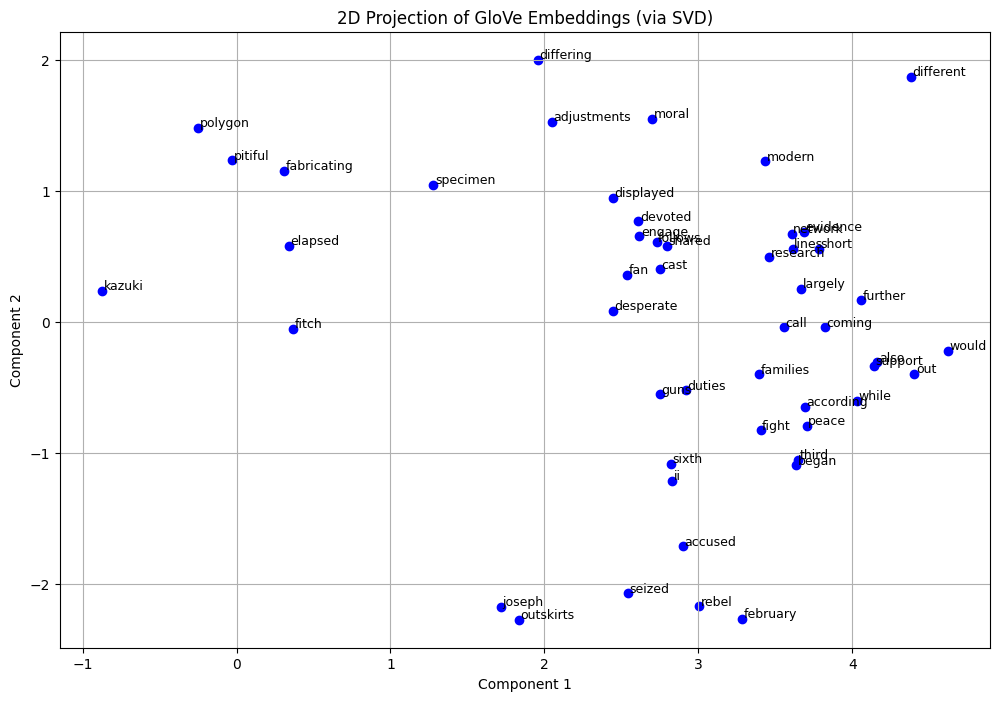

✅ Word2Vec vectors reduced to: (1618, 2)


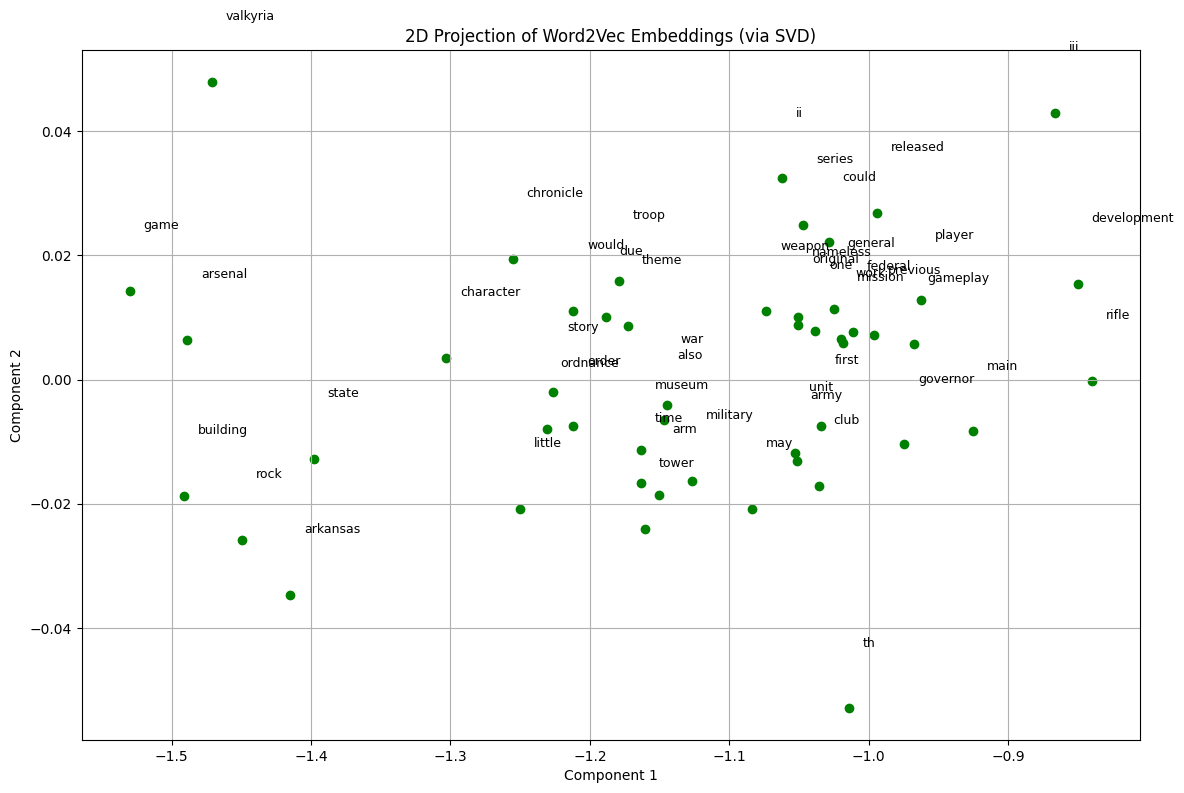

In [14]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# ----------- GloVe Visualization ----------
# Prepare matrix and word list
words_glove = list(embedding_matrix.keys())
vectors_glove = np.array([embedding_matrix[word] for word in words_glove])

# Reduce to 2D
svd_glove = TruncatedSVD(n_components=2, random_state=42)
vectors_glove_2d = svd_glove.fit_transform(vectors_glove)

print(f"✅ GloVe vectors reduced to: {vectors_glove_2d.shape}")

# Plot subset
plt.figure(figsize=(12, 8))
for i in range(50):
    x, y = vectors_glove_2d[i]
    plt.scatter(x, y, color='blue')
    plt.text(x + 0.01, y + 0.01, words_glove[i], fontsize=9)

plt.title("2D Projection of GloVe Embeddings (via SVD)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()


# ----------- Word2Vec Visualization ----------
# Extract vocab and vectors
w2v_words = list(w2v_model.wv.index_to_key)
w2v_vectors = np.array([w2v_model.wv[word] for word in w2v_words])

# Reduce to 2D
svd_w2v = TruncatedSVD(n_components=2, random_state=42)
w2v_vectors_2d = svd_w2v.fit_transform(w2v_vectors)

print(f"✅ Word2Vec vectors reduced to: {w2v_vectors_2d.shape}")

# Plot subset
plt.figure(figsize=(12, 8))
for i in range(50):
    x, y = w2v_vectors_2d[i]
    plt.scatter(x, y, color='green')
    plt.text(x + 0.01, y + 0.01, w2v_words[i], fontsize=9)

plt.title("2D Projection of Word2Vec Embeddings (via SVD)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()



---

### Word2Vec vs GloVe: Embedding Method Comparison

Below is a side-by-side comparison of the two word embedding techniques explored in this notebook. It outlines their core differences, training strategies, strengths, and how they apply to our use case with the Wikipedia corpus.

| Feature                | **Word2Vec**                                      | **GloVe**                                        |
| ---------------------- | ------------------------------------------------- | ------------------------------------------------ |
| **Model Type**         | Predictive Model                                  | Count-based Model                                |
| **Architecture**       | Neural Network (CBOW / Skip-Gram)                 | Matrix Factorization (Co-occurrence Matrix)      |
| **Context Scope**      | Local Context Window                              | Global Co-occurrence Statistics                  |
| **Captures**           | Semantic and Syntactic Similarity                 | Co-occurrence-Based Global Similarity            |
| **Corpus Suitability** | Better for medium-sized corpora                   | Best with large-scale corpora                    |
| **Impact on Our Task** | Captures contextual meaning from Wikipedia topics | General associations across a wide topic range   |
| **Advantages**         | Learns nuanced, context-sensitive embeddings      | Efficient to use with pretrained vectors         |
| **Limitations**        | Requires training time and parameter tuning       | Less adaptable to domain-specific vocabulary     |
| **Best Use Cases**     | Custom NLP tasks, chatbots, sentiment analysis    | Text similarity, clustering, feature engineering |

---



## Summary and Conclusion

This workshop presented a complete NLP pipeline combining traditional probabilistic language models with modern word embedding techniques, using the Simple English Wikipedia corpus as a practical dataset.

---

### NLP Pipeline Overview

We implemented a full preprocessing workflow including:

- **Normalization**: Lowercasing, removal of punctuation and numbers
- **Tokenization**: Treebank tokenizer via NLTK
- **Stopword Removal**: Standard English stopword filtering
- **Lemmatization**: Using WordNet lemmatizer for consistent word forms

---

### Probabilistic Language Models

We developed and evaluated:

- **Unigram**, **Bigram**, **Trigram**, and generalized **N-gram (4-gram)** models
- Applied **Laplace Smoothing** to handle unseen sequences

These models allowed sentence probability estimation and demonstrated how word dependencies evolve with context length.

---

### Word Embedding Techniques

We explored two major approaches to semantic representation:

- **Word2Vec (Skip-Gram)**: Trained on our cleaned corpus using `gensim`; captured contextual word relationships effectively.
- **GloVe (Pretrained)**: Loaded from `glove-wiki-gigaword-50`; provided fast, globally-trained embeddings for our vocabulary.

---

### Embedding Visualization

To interpret high-dimensional vector spaces, we applied **Truncated SVD** to project embeddings into 2D:

- **Word2Vec clusters**: Revealed topic-aware word groupings
- **GloVe clusters**: Showed global co-occurrence patterns across words

---

### Key Insight

- **Word2Vec** is effective for learning rich, domain-specific semantic relationships.
- **GloVe** excels in rapid deployment with reliable, general-purpose embeddings, especially when training resources are limited.

---

This notebook demonstrates how combining statistical language modeling with modern vectorization can provide deep insight into textual data. These models lay the groundwork for downstream applications such as text classification, clustering, topic modeling, or conversational agents.

